# And that is your challenge.

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
raw_data = pd.read_csv('epi_r.csv')

In [3]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [4]:
# Dropping nulls
df = raw_data.dropna()

In [5]:
# Creating dummy variable for High Rating
dummy = pd.get_dummies((df.rating >= 3.7), prefix='high_rating')

In [6]:
# Merging dummy variable to DataFrame
df = df.merge(dummy, left_index=True, right_index=True)

In [7]:
# Isolating recipes with high rating
dfhr = df[df['high_rating_True']==1]

In [8]:
# Isolating recipes with low rating
dflr = df[df['high_rating_True']==0]

In [9]:
dft = df.T
dfhrt = dfhr.T
dflrt = dflr.T

In [10]:
dfhrt['Totals'] = dfhrt[1:20051].sum(axis=1)

In [11]:
dflrt['Totals'] = dflrt[1:20051].sum(axis=1)

In [12]:
countcomp = pd.DataFrame()
countcomp['high'] = dfhrt['Totals']
countcomp['low'] = dflrt['Totals']
countcomp['total'] = countcomp['high'] + countcomp['low']
countcomp['percentage_high'] = countcomp['high'] / countcomp['total']
countcomp = countcomp.drop(['title', 'rating', 'calories', 'protein', 'fat', 'sodium','high_rating_True', 'high_rating_False'])
countcomp = countcomp.sort_values(by='percentage_high', ascending=False)
countcomp = countcomp.reset_index()
countcomp.rename(columns = {'index':'recipe name'}, inplace = True)

In [13]:
countcomp['recipe name'] = countcomp['recipe name'].str.replace('é', 'e')
countcomp['recipe name'] = countcomp['recipe name'].str.replace('ê', 'e')
countcomp['recipe name'] = countcomp['recipe name'].str.replace('ú', 'u')
countcomp['recipe name'] = countcomp['recipe name'].str.replace('í', 'i')

In [14]:
countcomp2 = countcomp[countcomp.total >=50].sort_values(by='percentage_high', ascending=False)
countcomp3 = countcomp[countcomp.total >=50].sort_values(by='percentage_high', ascending=True)

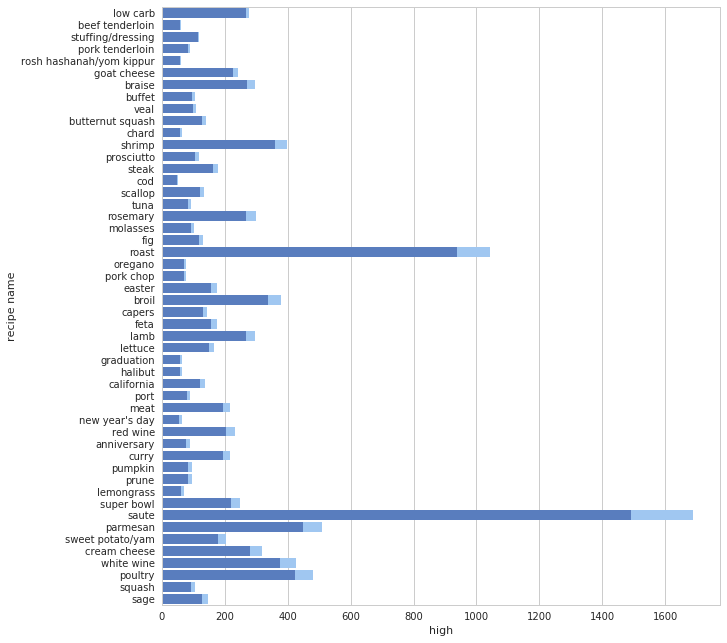

In [15]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 11))

# Plot the total frequency of words
sns.set_color_codes("pastel")
sns.barplot(x="total", y="recipe name", data=countcomp2[:50],
            label="Total", color="b")

# Plot the frequency of words in high-rated recipes
sns.set_color_codes("muted")
sns.barplot(x="high", y="recipe name", data=countcomp2[:50],
            label="High", color="b")

plt.show()

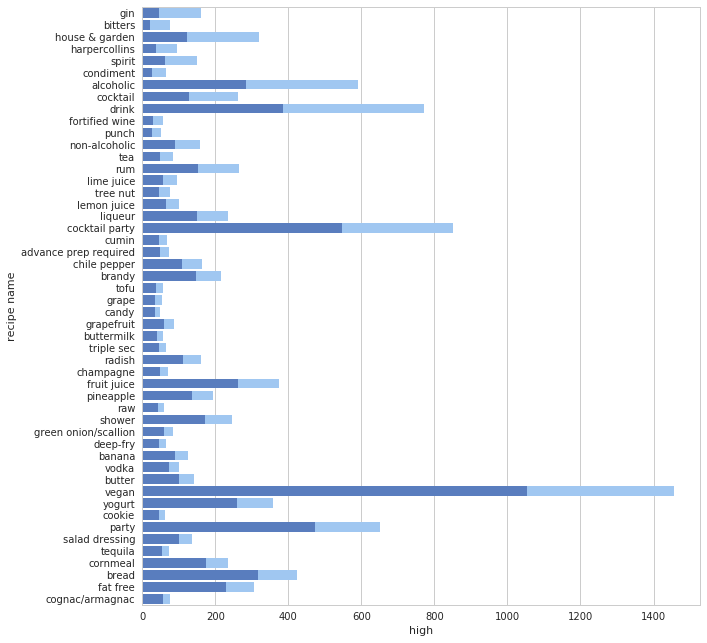

In [16]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 11))

# Plot the total frequency of words
sns.set_color_codes("pastel")
sns.barplot(x="total", y="recipe name", data=countcomp3[:50],
            label="Total", color="b")

# Plot the frequency of words in high-rated recipes
sns.set_color_codes("muted")
sns.barplot(x="high", y="recipe name", data=countcomp3[:50],
            label="High", color="b")

plt.show()

In [17]:
nutrition = df[['calories', 'protein', 'fat', 'sodium']]

In [18]:
features = df[['thanksgiving', 'roast', 'low carb', 'turkey', 'goat cheese', 'grill', 'steak', 'pear', 'house & garden', 'gin', 'low/no sugar', 'radish', 'bread', 'cabbage', 'fourth of july', 'cranberry', 'christmas', 'grill/barbecue', 'drink', 'pasta', 'stuffing/dressing', 'steak']]

# SVC Model with Selected Features

In [19]:
# Change from SVR to SVC to make it a classifier
from sklearn.svm import SVC
svc = SVC()
X = features
Y = df.high_rating_True
svc.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
svc.score(X, Y)

0.8138552697932425

In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score(svc, X, Y, cv=5)

array([0.81437126, 0.81311062, 0.81121967, 0.80995903, 0.81462799])

# SVC Model using PCA

In [22]:
# Let's try PCA as an alternative approach
from sklearn.svm import SVC
X = df.drop(['rating', 'title', 'high_rating_True', 'high_rating_False'], axis=1)

# Standardize the data
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [23]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components = 30)
Y_sklearn = sklearn_pca.fit_transform(X_std)

In [24]:
# Assign the components from the PCA to a new DataFrame
df_pca = pd.DataFrame()

for i in range(0, 30, 1):
    df_pca[i] = Y_sklearn[:, i]

In [25]:
# Find the optimal boundary and check the score with SVC now that the top 30 components have been identified

X_ = df_pca
Y_ = df.high_rating_True
svc.fit(X_,Y_)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
svc.score(X_, Y_)

0.8447428139183056

In [27]:
cross_val_score(svc, X_, Y_, cv=5)

array([0.81815317, 0.81689253, 0.81342578, 0.82004412, 0.81746532])

# SVC Model Selecting Features by Number of 0's

In [28]:
X = df[(df[df == 0].count()).sort_values()[:30].index.values].drop(['title', 'rating', 'high_rating_True'], 1)
svc.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [29]:
svc.score(X, Y)

0.9682929904185578

In [30]:
from sklearn.model_selection import cross_val_score
cross_val_score(svc, X, Y, cv=5)

array([0.83107469, 0.82855342, 0.82823826, 0.83296565, 0.83196721])

## Results

All of these show a vast improvement over the given SVR model. The models using the manually selected features and PCA performed reasonable well, though the PCA added a great deal of processing time to the model.  The best results were acheived by sorting and selecting features by the number of 0's in each column.